In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [52]:
labels = [
    "Walking",
    "Walking\nupstairs",
    "Walking\ndownstairs",
    "Sitting",
    "Standing",
    "Lying",
]

segments = []
with open("model_log") as f:
    lines_raw = [l.strip() for l in f.readlines()]
    new_segment = None
    for l in lines_raw:
        if l == "begin":
            new_segment = []
        elif l == "end":
            segments.append(new_segment)
            new_segment = None
        else:
            new_segment.append(l)

df = pd.DataFrame(
    [s.split() for seg in segments for s in seg],
    columns=["conf", "true", "pred", 0, 1, 2, 3, 4, 5],
).astype({
    "conf": "str",
    "true": "int",
    "pred": "int",
    0: "float", 1: "float", 2: "float", 3: "float", 4: "float", 5: "float",
})
del segments

sm_c = df.loc[:, [0, 1, 2, 3, 4, 5]]
df["min"] = sm_c.min(axis=1)
df["max"] = sm_c.max(axis=1)
df["var"] = sm_c.var(axis=1)
df["correct"] = (df["true"] == df["pred"]).astype(int)

df

,conf,true,pred,0,1,2,3,4,5,min,max,var,correct
0,conf0,5,5,3.701790e-07,3.966620e-07,5.709420e-06,5.185520e-07,6.763940e-09,9.999930e-01,6.763940e-09,0.999993,0.166664,1
1,conf0,4,3,4.426000e-07,3.186520e-06,7.070340e-06,9.999800e-01,5.963570e-06,2.873400e-06,4.426000e-07,0.999980,0.166659,0
2,conf0,3,3,3.288730e-07,2.117270e-06,4.556640e-06,9.999890e-01,2.253490e-06,1.903190e-06,3.288730e-07,0.999989,0.166662,1
3,conf0,0,0,1.000000e+00,1.225780e-10,2.113500e-11,4.788470e-11,3.392860e-12,2.703340e-11,3.392860e-12,1.000000,0.166667,1
4,conf0,3,3,4.424070e-07,2.920820e-06,6.369380e-06,9.999850e-01,3.083820e-06,2.628650e-06,4.424070e-07,0.999985,0.166661,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,conf9,3,3,2.051490e-03,8.476200e-03,2.346560e-01,7.230000e-01,1.317950e-02,1.863720e-02,2.051490e-03,0.723000,0.082345,1
14496,conf9,1,2,5.461050e-03,2.782110e-01,6.934100e-01,3.677390e-03,1.227080e-02,6.968780e-03,3.677390e-03,0.693410,0.078359,0
14497,conf9,1,1,6.430520e-03,9.597580e-01,3.134830e-02,6.544580e-04,1.176850e-03,6.315200e-04,6.315200e-04,0.959758,0.151099,1
14498,conf9,4,4,4.305800e-04,1.798270e-03,4.838590e-02,3.856110e-03,9.449260e-01,6.032690e-04,4.305800e-04,0.944926,0.145716,1


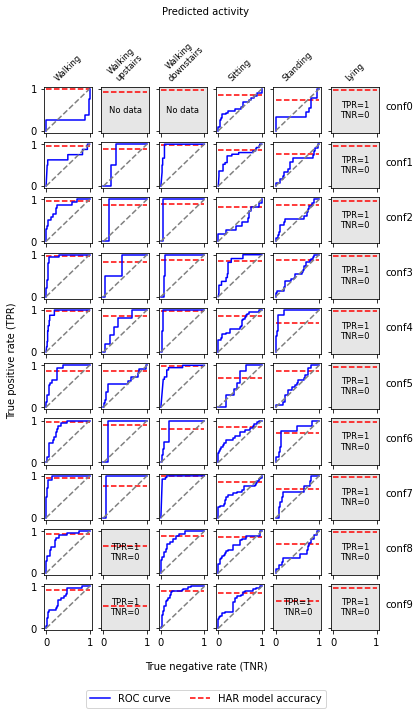

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from matplotlib.lines import Line2D

nlabels = len(df["true"].unique())
nconfs = len(df["conf"].unique())


accuracies = df.groupby(["conf", "true"]).agg({'correct': 'sum', 'pred': 'count'})
accuracies["acc"] = accuracies["correct"] / accuracies["pred"]

fig, axs = plt.subplots(nrows=nconfs, ncols=nlabels, figsize=(6, 10), sharex=True, sharey=True)
for i, (conf, grpc) in enumerate(df.groupby(["conf"])):
    for j, (label, grp) in enumerate(grpc.groupby(["pred"])):

        ax = axs[i, label]

        feats = ["min", "max", "var"]
        clz = "correct"
        X, y = grp.loc[:, feats], grp.loc[:, clz]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        acc = accuracies.loc[conf].loc[label].acc

        ax.set_ylim(-0.05, 1.05)
        ax.hlines(acc, 0, 1, colors='r', linestyles='--')

        classifier = GaussianNB()
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        plot_kw = dict(c='b')

        def text(s): return ax.text(0.5, 0.5, s, ha='center', va='center', fontsize='small')

        if np.all(y_pred == 0):
            # TPR = 0
            # TNR = 1
            ax.set_facecolor((0.9, 0.9, 0.9))
            text("TPR=0\nTNR=1")
        elif np.all(y_pred == 1):
            # TPR = 1
            # TNR = 0
            ax.set_facecolor((0.9, 0.9, 0.9))
            text("TPR=1\nTNR=0")
        elif np.any(y_test == 0) and np.any(y_test == 1):
            # else:
            # dsp = plot_roc_curve(classifier, X_test, y_test, ax=ax, pos_label=1, name=f"Predicting correct")
            dsp = plot_roc_curve(classifier, X_test, y_test, ax=ax, pos_label=0,
                                 name=f"Predicting incorrect", **plot_kw)
            ax.plot([0, 1], [0, 1], '--', c='gray')
            ax.legend().remove()
        else:
            text("No data")
            ax.set_facecolor((0.9, 0.9, 0.9))

        ax.set_ylabel("")
        ax.set_xlabel("")

        # if i == len(axs)-1:
        #     ax.set_xlabel("TNR")

        if label == len(labels)-1:
            ax.text(1.2, 0.5, conf)

        if i == 0:
            ax.set_title(f"{labels[label]}", rotation=45, fontsize='small')

fig.text(0.5, 0.98, "Predicted activity", ha='center')  # x

fig.text(0.5, 0.07, "True negative rate (TNR)", ha='center')  # x
fig.text(0.04, 0.5, "True positive rate (TPR)", va='center', rotation='vertical')  # y

legend_elements = [Line2D([0], [0], c='b',ls='-', label='ROC curve'),
                   Line2D([0], [0], c='r',ls='--', label='HAR model accuracy'), ]
fig.legend(handles=legend_elements, ncol=2, loc='center', bbox_to_anchor=(0,0.03,1,0))


plt.savefig("roc-confidence-bayes.pdf", bbox_inches='tight')
plt.show()
